In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from tool_functions.feature_fuser import *

feature_path = []
rgb_path = []
true_label_path = []
size = 0

folder_path = '/home/xi/workspace/bonn_features/'
feature_file_list = os.listdir(folder_path)
for file_name in feature_file_list:
    if file_name.find('.npy') != -1:
        # print(file_name[:-13])
        rgb_p = folder_path + file_name[:-4] + '_img.jpg'
        label_p = folder_path + file_name[:-4] + '_img_label.png'
        path = file_name

        feature_path.append(folder_path + path)
        rgb_path.append(rgb_p)
        true_label_path.append(label_p)


print('feature loaded:', len(feature_path))
# print(true_label_path)

def process_feature(f_img):
    result_img = np.full(f_img.shape, 0, dtype=np.uint8)
    for row in range(f_img.shape[0]):
        for col in range(f_img.shape[1]):
            f_v = f_img[row, col]
            if f_v > 0.2:
                result_img[row, col] = 255

    return result_img


image loaded: 81
feature loaded: 29


In [2]:
def load_feature_file():
    count = 0
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []
    
#     test_index = np.random.choice(29, 5, replace=False)
#     test_files = [2,3,5,10,13,24,28]
    test_files = [2]
    test_index = []
    
    
    for (feature_file, rgb_file, l_file) in zip(feature_path, rgb_path, true_label_path):
        features_map = np.load(feature_file)
        rgb_img = cv2.imread(rgb_file, 1)
        true_label_img = cv2.imread(l_file, 0)/50
        
        img_index = rgb_file[len(folder_path):-8]
#         print(rgb_file[len(folder_path):-8])
        
        is_train = True
        for i in range(len(test_files)):
            if img_index == str(test_files[i]):
                is_train = False
                test_index.append(count)
                print(is_train, feature_file, features_map.shape, true_label_img.shape, count)
                break
            
#         print(is_train, feature_file, features_map.shape, true_label_img.shape, count)
        count += 1

        # features = features_map[:,:,:-1]
        # labels =   features_map[:,:,-1]
    
        # shape = features.shape
        # features_reshaped = features.reshape(shape[0]*shape[1], shape[2])

        features_map_reshape = features_map.reshape((features_map.shape[0]*features_map.shape[1], features_map.shape[2]))
        label_reshape = true_label_img.reshape(true_label_img.shape[0]*true_label_img.shape[1])
        if is_train:
            if len(train_features) == 0:
                train_features = features_map_reshape
                train_labels = label_reshape
            else:
                train_features = np.concatenate((train_features,features_map_reshape), axis=0)
                train_labels = np.concatenate((train_labels,label_reshape), axis=0)
            
#             train_features.append(features_map_reshape)
#             train_labels.append(label_reshape)      

#         for row in range(size, features_map.shape[0]-size, 1+size):
#             for col in range(size, features_map.shape[1]-size, 1+size):
#                 feature = features_map[row-size:row+size+1, col-size:col+size+1].flatten()
#                 label = int(true_label_img[row, col]/50)
#                 if label != -1 and label != 0:
#                     if is_train:
#                         train_features.append(feature)
#                         train_labels.append(label)
#                     else:
#                         test_features.append(feature)
#                         test_labels.append(label)
        
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
#     test_features = np.array(test_features)
#     test_labels = np.array(test_labels)
    
    print(train_features.shape, train_labels.shape)

    return train_features, train_labels, test_index

In [3]:
train_features, train_labels, test_index = load_feature_file()
print(test_index)

False /home/xi/workspace/bonn_features/2.npy (540, 960, 39) (540, 960) 28
(14515200, 39) (14515200,)
[28]


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_features)

X_train = scaler.transform(train_features)
# X_test = scaler.transform(test_features)

y_train = train_labels
# y_test = test_labels

# X = StandardScaler().fit_transform(all_features)
# X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=.4, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=30, n_estimators=10, max_features=1)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
def classify_features(features_map, true_label_img, rgb_img):
    pred_img = np.full((540, 960, 3), 0, np.uint8)
    true_img = np.full((540, 960, 3), 0, np.uint8)

    features_map_reshape = features_map.reshape((features_map.shape[0]*features_map.shape[1], features_map.shape[2]))
    feature_nromalized = scaler.transform(features_map_reshape)
    print('predicting.....')
    label_pred = clf.predict(feature_nromalized)

#     true_label = true_label_img.reshape(true_label_img.shape[0]*true_label_img.shape[1])/50
#     score = clf.score(feature_nromalized, true_label)
#     print ('score', score)
    
    print('predected!', label_pred.shape)
    label_pred_reshaped = label_pred.reshape((features_map.shape[0], features_map.shape[1]))

    total_count = 0
    correct_count = 0
    
    for row in range(features_map.shape[0]):
        for col in range(features_map.shape[1]):
            label_pred = label_pred_reshaped[row, col]
            true_label = true_label_img[row, col]/50
            
            if true_label == 5: #narrow passage
                true_img[row, col] = [255, 255, 0]
            if true_label == 4: #stair
                true_img[row, col] = [255, 255, 0]
            if true_label == 3: #obs
                true_img[row, col] = [0, 0, 255]     
            if true_label == 2: #rough
                true_img[row, col] = [0, 255, 0]  
            if true_label == 1: #safe
                true_img[row, col] = [255, 0, 0] 
                    
                    
                    
            if features_map[row, col, 0] != -1:
                total_count += 1
                if label_pred == true_label:
                    correct_count += 1
                
                if label_pred == 5: #narrow passage
                    cv2.circle(pred_img, (col, row), 3, (255, 255, 0), -1)                
                if label_pred == 4: #stair
                    cv2.circle(pred_img, (col, row), 5, (255, 255, 0), -1)
                if label_pred == 3: #obs
                    cv2.circle(pred_img, (col, row), 3, (0, 0, 255), -1)     
                if label_pred == 2: #rough
                    cv2.circle(pred_img, (col, row), 3, (0, 255, 0), -1)  
                if label_pred == 1: #safe
                    cv2.circle(pred_img, (col, row), 3, (255, 0, 0), -1) 

    print(correct_count, total_count, correct_count/total_count)
    return pred_img, true_img, correct_count/total_count

28
/home/xi/workspace/bonn_features/2.npy
predicting.....
predected! (518400,)
16286 17920 0.9088169642857142
/home/xi/bonn_images/2


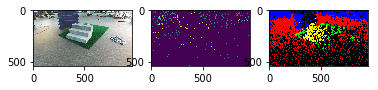

0.9088169642857142


In [10]:
sum_score = 0
for i in range(len(test_index)):

    index = test_index[i]
    print(index)
#     index = 1
    feature_file = feature_path[index]
    rgb_file = rgb_path[index]
    l_file = true_label_path[index]
    true_label_img = cv2.imread(l_file, 0)
    
    print(feature_file)
    features_map = np.load(feature_file)
    rgb_img = cv2.imread(rgb_file, 1)
    
    pred_img, true_img, score = classify_features(features_map, true_label_img, rgb_img)
    h_stair = features_map[:, :, 4]*255
    
    sum_score += score
#     print(true_label_img)
#     print(pred_img)
    
    test_size = len(test_index)
    index = 2
    file_base = "/home/xi/bonn_images/"+feature_file[33:-4]
    print(file_base)
    cv2.imwrite(file_base +'_img.png', rgb_img)
    cv2.imwrite(file_base +'_label.png', true_img)
    cv2.imwrite(file_base +'_pred.png', pred_img)
    cv2.imwrite(file_base +'_stair.png', h_stair)
    
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(rgb_img)
    f.add_subplot(1,3, 2)
    plt.imshow(h_stair)   
    f.add_subplot(1,3, 3)
    plt.imshow(pred_img)      
    plt.show()  
    
print (sum_score/len(test_index))
    
    

In [9]:
def normalize_img(img, max_value):
    
    img_clip = np.clip(img, 0, max_value)
    
    img_norm = img_clip/max_value *255
    
    return img_norm

In [ ]:
# score = clf.score(X_test, y_test)
# print (score)

/home/xi/workspace/bonn_features/14.npy


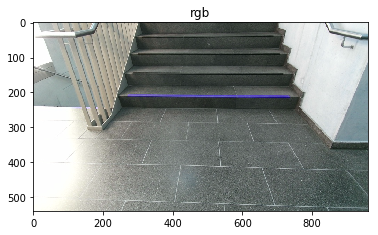

In [ ]:
# for i in range(len(test_index)):
for i in range(1, 2, 1):

#     index = test_index[i]
    index = 1
    feature_file = feature_path[index]
    rgb_file = rgb_path[index]
    l_file = true_label_path[index]
    
    print(feature_file)
    features_map = np.load(feature_file)
    stair_img = features_map[:,:,4]
    rgb_img = cv2.imread(rgb_file, 1)
    true_label_img = cv2.imread(l_file, 0)
    
    plt.imshow(rgb_img)
    plt.title('rgb')
    plt.show()
    
    hd = features_map[:, :, 0]
    slope = features_map[:, :, 1]
    roughness = features_map[:, :, 2]
    dist = features_map[:, :, 3]
    h_stair = features_map[:, :, 4]
    
    hd = normalize_img(hd, 0.5)
    slope = normalize_img(slope, 0.2)
    roughness = normalize_img(roughness, 0.6)
    dist = normalize_img(dist, dist.max())
    h_stair = normalize_img(h_stair, 1)
    
    predict_img = np.full((rgb_img.shape[0], rgb_img.shape[1]), 0, np.uint8)
    
    for row in range(size, features_map.shape[0]-size, 1):
        for col in range(size, features_map.shape[1]-size, 1):
            feature = features_map[row-size:row+size+1, col-size:col+size+1].flatten()
            feature_nromalized = scaler.transform([feature])
            
            label = true_label_img[row, col]
            if label != -1:
                label_pred = int(clf.predict(feature_nromalized)[0])
                if label_pred == 4: #stair
                    cv2.circle(rgb_img, (col, row), 3, (255, 255, 0), -1)
                if label_pred == 3: #obs
                    cv2.circle(rgb_img, (col, row), 3, (0, 255, 0), -1)     
                if label_pred == 2: #rough
                    cv2.circle(rgb_img, (col, row), 3, (0, 255, 255), -1)  
                if label_pred == 1: #safe
                    cv2.circle(rgb_img, (col, row), 3, (0, 0, 255), -1)                      
                predict_img[row, col] = label_pred*50
#                 print(label_pred, label)
#     break
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(predict_img)
    f.add_subplot(1,2, 2)
    plt.imshow(true_label_img)      
    plt.show()  

#     plt.imshow(hd, cmap='gray')
#     plt.title('high difference')
#     plt.show()

#     plt.imshow(slope, cmap='gray')
#     plt.title('slope')
#     plt.show()
    
#     plt.imshow(roughness, cmap='gray')
#     plt.title('roughness')
#     plt.show()
    
#     plt.imshow(h_stair, cmap='gray')
#     plt.title('stair detction')
#     plt.show()
    
#     plt.imshow(true_label_img)
#     plt.title('true_label_img picture')
#     plt.show()        
                